In [1]:
import torch
import json
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from scipy.spatial import distance
from scipy.stats import percentileofscore



/!\ Disclaimer: it is possible that dataframes indices are treated as integers instead of strings (or the opposite) in this notebook depending on how you import the data

The aim of this notebook is to look at the position of a nearest neighbour in another latent space (constructed with the same data):

- take a vector idx in a latent space A and find its nearest neighbour (nn)
- calculate the distance between idx and nn in a latent space B. (B is supposed to contain the representation of the same elements than in A.)
- rank nn in terms of distance to idx in B (it is first if it is still the closest to idx in B and last if it is the furthest)
- do stats on that

This is a proxy to see if the structure of a latent space is conserved from one to another (a couple of points that are close in a latent space souldn't be too far in the other one).

# Load the data

In [2]:
def load_embeddings(verbose=False):    
    # load embeddings
    dir_path = "/neurospin/dico/agaudin/Runs/01_tests_kraken/Output"
    path1 = dir_path + "/2022-05-10/11-57-32/train_val_embeddings.pt"
    path2 = dir_path + "/2022-05-11/11-38-50/train_val_embeddings.pt"
    embeddings1 = torch.load(path1)
    embeddings2 = torch.load(path2)

    # load labels
    dir_path = "/neurospin/dico/agaudin/Runs/01_tests_kraken/Output"
    label_path1 = dir_path + "/2022-05-10/11-57-32/train_val_filenames.json"
    label_path2 = dir_path + "/2022-05-11/11-38-50/train_val_filenames.json"

    with open(label_path1, 'r') as f:
        labels1 = json.load(f)

    with open(label_path2, 'r') as f:
        labels2 = json.load(f)

    if verbose:
        print(labels1[:20])
        print(labels2[:20])

        print(labels1 == labels2)

    # create dataframes for both runs
    embeddings1 = pd.DataFrame(embeddings1.numpy(), index=labels1,
                            columns=["dim1", "dim2", "dim3", "dim4"])

    embeddings2 = pd.DataFrame(embeddings2.numpy(), index=labels2,
                            columns=["dim1", "dim2", "dim3", "dim4"])

    return embeddings1, embeddings2

embeddings1, embeddings2 = load_embeddings(verbose=True)

['129634', '136833', '206222', '138837', '987983', '562345', '182032', '275645', '151021', '177342', '578057', '186444', '206525', '131621', '887373', '412528', '869472', '573249', '151930', '529953']
['129634', '136833', '206222', '138837', '987983', '562345', '182032', '275645', '151021', '177342', '578057', '186444', '206525', '131621', '887373', '412528', '869472', '573249', '151930', '529953']
True


# Plot the scatter matrices of the two df

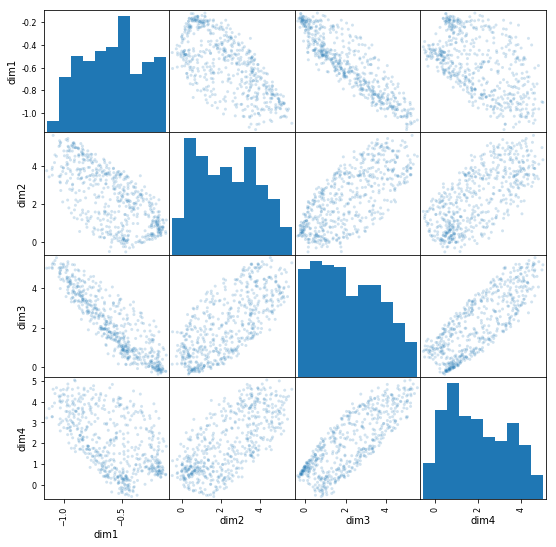

In [3]:
sm1 = scatter_matrix(embeddings1[["dim1", "dim2", "dim3", "dim4"]], alpha=0.2, figsize=(9,9))

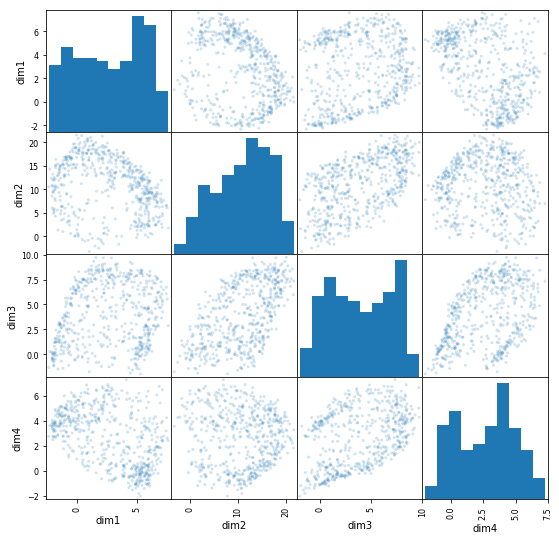

In [4]:
sm2 = scatter_matrix(embeddings2[["dim1", "dim2", "dim3", "dim4"]], alpha=0.2, figsize=(9,9))

# Get the nearest neighbour

In [5]:
# tests distance.euclidian
line1 = embeddings1.iloc[1,:]
line2 = embeddings1.iloc[2,:]
print(line1)
print(line2)

print(distance.euclidean(line1, line2))

embeddings1.apply(distance.euclidean, axis=1, args=[np.array(line1)])

dim1   -0.797975
dim2    3.451934
dim3    3.221163
dim4    1.872150
Name: 136833, dtype: float32
dim1   -0.685228
dim2    1.154366
dim3    2.052891
dim4    0.591066
Name: 206222, dtype: float32
2.880549669265747


129634    2.104802
136833    0.000000
206222    2.880550
138837    1.697781
987983    4.421124
562345    3.102693
182032    4.757180
275645    4.029875
151021    4.302710
177342    3.656858
578057    3.371672
186444    1.608401
206525    2.109181
131621    2.068362
887373    2.385904
412528    2.574054
869472    0.593813
573249    3.771940
151930    4.612475
529953    2.494976
120515    1.171962
770352    2.678762
667056    2.624495
966975    1.425042
127731    1.052058
123824    0.459599
211316    2.451900
192439    5.216658
705341    2.882617
174437    4.793007
            ...   
189450    2.352690
268850    2.840188
176441    4.787887
199958    4.351205
189349    3.375395
679770    2.016728
571548    2.724582
366446    4.363422
933253    3.248039
122418    2.569334
103515    3.866666
723141    4.408516
598568    2.423585
352132    2.542774
150019    2.993237
123420    4.772974
349244    3.381060
163331    3.489305
663755    1.628166
623844    2.840918
395958    1.911453
154734    2.

In [6]:
# get the nearest neighbour of a line of the dataset df
# returns the label of the nn and its distance to the line
def get_nearest_neighbour(line, df, dist=distance.euclidean):
    idx = line.name
    df_without_line = df[df.index != idx]
    distances = df_without_line.apply(dist, axis=1, args=[np.array(line)]).to_frame()
    nn = distances.idxmin()[0]
    min_dist = distances[0][nn]
    return [nn, min_dist]

In [7]:
get_nearest_neighbour(line1, embeddings1)

['599671', 0.19314485788345337]

In [8]:
# get the nearest neighbours and their distance for the first run

nearest_neighbours1 = embeddings1.apply(get_nearest_neighbour, axis=1, result_type='expand', 
                                          args=[embeddings1])
embeddings1['nn'] = nearest_neighbours1[0]
embeddings1['min_dist'] = nearest_neighbours1[1]
embeddings1

,dim1,dim2,dim3,dim4,nn,min_dist
129634,-0.775925,3.293138,4.059559,3.796100,131621,0.313544
136833,-0.797975,3.451934,3.221163,1.872150,599671,0.193145
206222,-0.685228,1.154366,2.052891,0.591066,165941,0.231168
138837,-0.848134,4.762355,2.413001,2.586024,168745,0.435338
987983,-0.206783,1.053893,-0.187561,0.520546,833148,0.162571
562345,-0.926353,4.789825,4.624770,4.290860,825654,0.326648
182032,-0.238397,0.148985,0.020995,0.791832,107422,0.144767
275645,-0.595139,-0.242363,1.763372,1.219638,121921,0.250688
151021,-0.235907,1.023930,-0.074977,0.673128,833148,0.047059
177342,-0.406048,1.737580,0.832920,-0.267076,748662,0.095801


In [9]:
# get the nearest neighbours and their distance for the second run

nearest_neighbours2 = embeddings2.apply(get_nearest_neighbour, axis=1, result_type='expand',
                                          args=[embeddings2])
embeddings2['nn'] = nearest_neighbours2[0]
embeddings2['min_dist'] = nearest_neighbours2[1]
embeddings2

,dim1,dim2,dim3,dim4,nn,min_dist
129634,5.639729,12.073092,6.448773,1.544477,770352,0.812938
136833,1.892567,17.259123,8.317280,3.961068,144832,0.335078
206222,4.882368,4.574408,-1.034122,-1.367684,586460,0.788929
138837,0.534400,15.400150,0.982041,0.471511,779370,0.448252
987983,-1.839562,10.499065,0.809728,3.830457,151526,0.720049
562345,2.687701,18.222134,7.706027,2.393204,198653,0.488291
182032,0.128953,-0.059218,0.448809,4.224849,199958,0.846785
275645,5.963222,4.957520,4.557027,3.339703,131621,0.582963
151021,-1.868920,12.019956,0.058218,3.162699,148335,0.527771
177342,2.549029,13.414025,0.779020,-0.164430,173233,0.381740


In [10]:
# save embeddings 1 and 2 as csv files
embeddings1.to_csv("embeddings_05-10.csv")
embeddings2.to_csv("embeddings_05-11.csv")

# Get distance matrices

In [11]:
def get_distance_matrix(emb, verbose=False):
    # emb should not have the nn nor the min_dist columns    
    dist_mat = pd.DataFrame()

    for idx in emb.index:
        line = emb[emb.index == idx]
        if verbose:
            print(line)
        distances = emb.apply(distance.euclidean, axis=1, args=[np.array(line)])
        dist_mat[idx] = distances

    return dist_mat

In [12]:
# reload the original files for them not to have the 'nn' and 'min_dist' columns
embeddings1, embeddings2 = load_embeddings()

# generate the distance matrices
dist_mat1 = get_distance_matrix(embeddings1)
dist_mat2 = get_distance_matrix(embeddings2)

# save the distance matrices
dist_mat1.to_csv("distance_mat_05-10.csv")
dist_mat2.to_csv("distance_mat_05-11.csv")

# NN analysis

In [13]:
# load the tables with the 'nn' and 'min_dist' columns
embeddings1 = pd.read_csv("embeddings_05-10.csv", index_col=0)
embeddings2 = pd.read_csv("embeddings_05-11.csv", index_col=0)

### Calculate the proportion of nn that are still nn in the other latent space

In [14]:
def nearest_neighbours_conservation(emb1, emb2):
    # emb1 and emb2 should contain the nn column already
    if False in (emb1.index == emb2.index):
        raise ValueError("emb1 and emb2 should contain the same elements")
    else:
        same_nn = (emb1.nn == emb2.nn)
        return same_nn, same_nn.mean()
        

In [15]:
same_nn, ratio = nearest_neighbours_conservation(embeddings1, embeddings2)
# ratio of vectors that keep their nn
print(same_nn.sum(),"elements,",ratio*100, "% of the dataset")


27 elements, 4.90909090909 % of the dataset


Only 5% of all vectors keep their nearest neighbour through the two runs

In [16]:
# list of vectors that keep their nn (+ their nn in the 2nd column)
embeddings1[same_nn == True]['nn']

192439    196952
185442    568963
889579    849971
517239    134425
397154    159946
214625    186040
707749    212015
114621    380036
186040    214625
901139    107220
150928    106319
159138    779370
810843    129129
664757    616645
201111    189450
163836    705341
131217    675661
540436    748258
196144    891667
134425    517239
107220    901139
146634    224022
616645    664757
129129    810843
188751    930449
733548    200210
349244    894673
Name: nn, dtype: int64

### Visualisation of single nearest neighbour position in the other latent space

rand_idx 614439
nearest_neighbours: 140925 199958

3.6363636363636362%, 20-th element


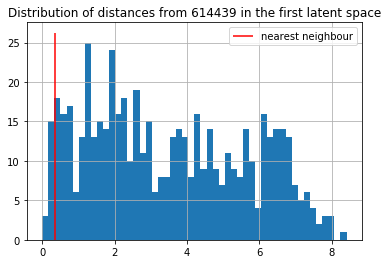

3.4545454545454546%, 19-th element


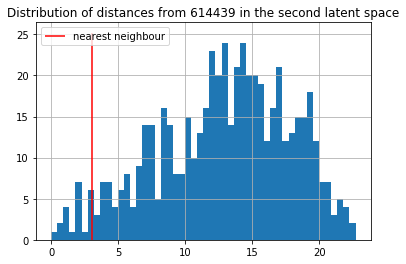

In [17]:
# choose a random index
rand_idx = rd.choice(embeddings1.index)
print("rand_idx", rand_idx)

# get the nn of rand_idx for both latent spaces
nn1 = str(embeddings1.nn[rand_idx])
nn2 = str(embeddings2.nn[rand_idx])
print("nearest_neighbours:", nn1, nn2)
print()

# get the distances from rand_idx in the first latent space
dist2nn1 = dist_mat1[str(rand_idx)]
dist2nn1.hist(bins=50)
dist1 = dist2nn1[nn2]  # distance of nn2 in the first latent space
# calculate the percentile of dist(rand_idx, nn2) in the first latent space
percentile = percentileofscore(dist2nn1, dist1)
print(f'{percentile}%,', f'{int(percentile*len(dist2nn1)/100)}-th element')
# plot the distance distribution
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.vlines(dist1, ymin=ymin, ymax=ymax, colors='red') # show position of nn in the other
                                                      # latent space
plt.title(f"Distribution of distances from {rand_idx} in the first latent space")
plt.legend(["nearest neighbour"])
plt.show()

# same thing for the second latent space (and nn1)
plt.figure()
dist2nn2 = dist_mat2[str(rand_idx)]
dist2nn2.hist(bins=50)
dist2 = dist2nn2[nn1]
percentile = percentileofscore(dist2nn2, dist2)
print(f'{percentile}%,', f'{int(percentile*len(dist2nn2)/100)}-th element')
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.vlines(dist2, ymin=ymin, ymax=ymax, colors='red')
plt.title(f"Distribution of distances from {rand_idx} in the second latent space")
plt.legend(["nearest neighbour"])
plt.show()

### Average percentile of nn in the other latent space

In [18]:
def get_percentile(distance_distrib_a, embeddings_b):
# distance_distrib_a is the distance distribution of idx in the latent space a, ie a column 
# (or line) of the associated dist_mat
    idx = int(distance_distrib_a.name)
    nn = embeddings_b.nn[idx] ## nn is the nearest neighbour of idx in the latent space b
    
    dist_a = distance_distrib_a[str(nn)]
    percentile = percentileofscore(distance_distrib_a, dist_a)
    
    return percentile

In [19]:
# function test


distance_distrib = dist_mat1['517239']  # pick an element
print(get_percentile(distance_distrib, embeddings2))

dist_mat1.apply(get_percentile, axis=0, args=[embeddings2])

0.363636363636


129634     1.090909
136833    31.090909
206222     8.545455
138837    10.000000
987983    26.727273
562345    21.636364
182032     2.727273
275645    74.363636
151021     2.909091
177342    48.363636
578057    55.090909
186444    12.727273
206525    48.727273
131621    70.727273
887373    70.000000
412528     4.181818
869472     1.272727
573249     4.363636
151930    29.272727
529953     3.636364
120515    59.090909
770352     1.818182
667056     3.090909
966975    35.818182
127731    12.909091
123824     1.636364
211316    44.181818
192439     0.363636
705341     2.363636
174437     2.363636
            ...    
189450     3.454545
268850     0.545455
176441     9.454545
199958     4.909091
189349     0.727273
679770    39.090909
571548     8.727273
366446    47.636364
933253    36.909091
122418    71.636364
103515    29.090909
723141     5.636364
598568    31.454545
352132     9.454545
150019     3.272727
123420     0.545455
349244     0.363636
163331     4.363636
663755     2.545455


In [20]:
def get_average_percentile(dist_mat1, dist_mat2, emb1, emb2):
# computes the average percentile a nn is sent to in the other latent space
    average_percentile_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2]).mean()
    average_percentile_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1]).mean()
    return (average_percentile_a + average_percentile_b) / 2

In [21]:
average_percentile = get_average_percentile(dist_mat1, dist_mat2, embeddings1, embeddings2)
print(f'{average_percentile}%,', f'{average_percentile*550/100}-th element')

14.071404958677686%, 77.39272727272727-th element


A nearest neighbour in one space is on average the 77th closest element in the other space

### Position stats of nn in the other latent space

In [22]:
def get_nn_stats(dist_mat1, dist_mat2, emb1, emb2):
    percentiles_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2])
    percentiles_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1])
    mean_a = percentiles_a.mean()
    mean_b = percentiles_b.mean()
    std_a = percentiles_a.std()
    std_b = percentiles_b.std()
    
    percentiles = pd.concat([percentiles_a, percentiles_b], axis=0, ignore_index=True)
    med = percentiles.median()
    first_quartile = percentiles.quantile(0.25)
    third_quartile = percentiles.quantile(0.75)

    nn_stats = {'mean': (mean_a + mean_b) / 2,
                'standard deviation': (std_a + std_b) / 2,
                'median': med,
                'first quartile': first_quartile,
                'third quartile': third_quartile}
    
    return nn_stats


In [23]:
get_nn_stats(dist_mat1, dist_mat2, embeddings1, embeddings2)

{'mean': 14.071404958677686,
 'standard deviation': 17.796229746155035,
 'median': 6.0,
 'first quartile': 2.181818181818182,
 'third quartile': 17.863636363636367}

Half of the nn in one space are in the 6% best (=closest to the same element) in the second latent space.

### Histogram of position of nn in the other latent space


In [24]:
def get_percentile_histograms(dist_mat1, dist_mat2, emb1, emb2, separate=False,
                              show_average=False, show_median=True, vlines_width=0.5):
    
    percentiles_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2])
    percentiles_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1])

    if separate:
        # compute the histogram
        percentiles_a.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles_a.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles_a.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn2 in the latent space 1")

        plt.figure()
        percentiles_b.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles_b.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles_b.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn1 in the latent space 2")

    
    else:
        percentiles = pd.concat([percentiles_a, percentiles_b], axis=0, ignore_index=True)
        percentiles.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn in the other latent space")
    

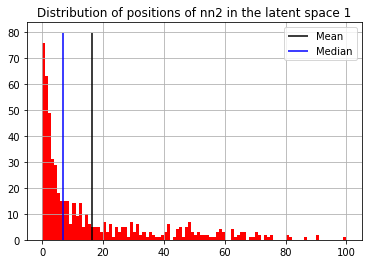

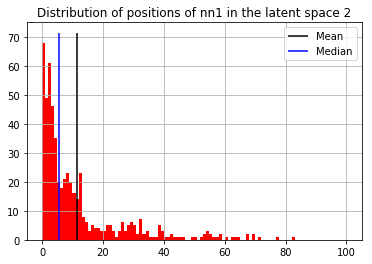

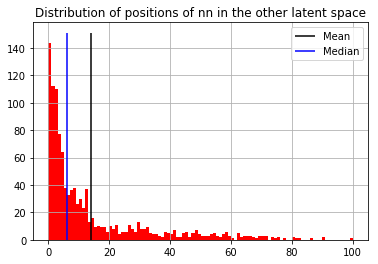

In [28]:
get_percentile_histograms(dist_mat1, dist_mat2, embeddings1, embeddings2, separate=True,
show_average=True)
plt.figure()
get_percentile_histograms(dist_mat1, dist_mat2, embeddings1, embeddings2, separate=False,
show_average=True)